#**Benchmark**

**คำอธิบาย**


*   ดัดแปลงจาก MobileNetV3Small Minimalistic
*   Test on Rice Dataset รอบที่ 1 SEED = 42



#**Section 1: Import Important Library**

In [1]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import pytz
from time import time

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import font_manager
import seaborn as sns
import itertools
import psutil

import cv2
import shutil
import PIL
import os
from pathlib import Path
import sys

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize, LabelEncoder, LabelBinarizer

import random as rd
import numpy as np
import zipfile

In [2]:
import tensorflow as tf
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

In [3]:
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/projectPlant/Colab')
from my_model import *
from helper_functions import *

Mounted at /content/drive


**Detail of Python Notebook in Google Colab**

In [4]:
!nvidia-smi

import subprocess
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print("-------------------------------------------------------------")
print(f"Python {sys.version}")
print("-------------------------------------------------------------")

# ตรวจสอบ GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Running on GPU")
    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of GPUs Available: {len(gpus)}")

    # ดึงข้อมูล GPU Memory
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=memory.total', '--format=csv,noheader,nounits'],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        gpu_memory = result.stdout.strip().split('\n')
        for idx, mem in enumerate(gpu_memory):
            print(f"GPU {idx}: Total Memory: {int(mem) / 1024:.2f} GB")
    except FileNotFoundError:
        print("nvidia-smi is not available on this system.")
else:
    print("No GPU detected. Running on CPU")
    strategy = tf.distribute.get_strategy()

# แสดงจำนวนอุปกรณ์ที่พร้อมใช้งาน
print("Number of replicas:", strategy.num_replicas_in_sync)
print("-------------------------------------------------------------")

# แสดงจำนวน RAM ทั้งหมด
total_ram = psutil.virtual_memory().total / (1024 ** 3)
print(f"Total RAM of Colab instance: {total_ram:.2f} GB")
print("-------------------------------------------------------------")

# แสดงเวลาปัจจุบันในเขตเวลาไทย
thailand_tz = pytz.timezone('Asia/Bangkok')
current_time = datetime.now(thailand_tz).strftime("%Y-%m-%d %H:%M:%S")
print("Current Time (Thailand):", current_time)

Tue Aug 26 02:50:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Initialize Setting (Focus First)**

In [5]:
SEED=42
np.random.seed(SEED)
tf.random.set_seed(SEED)
rd.seed(SEED)
BATCH_SIZE = 16

In [6]:
root_dir = '/content/drive/MyDrive/projectPlant/'
title = 'Rice Dataset'
dataset_name = 'riceDataset'
dataset_dir = root_dir + dataset_name

In [7]:
current_dir = os.getcwd()

In [8]:
zip_filename = 'rice_dataset_raw.zip'
zip_dir = dataset_dir + '/' + zip_filename

with zipfile.ZipFile(zip_dir, 'r') as zip_ref: # แตกไฟล์จาก G-Drive มาที่ Runtime Directory
    zip_ref.extractall(current_dir)
print(f"Unzip complete at {current_dir}")

Unzip complete at /content


In [9]:
locations = [f"{root_dir}Extra2/Font"]
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(font_files[0])
for file in font_files:
  font_manager.fontManager.addfont(file)

/content/drive/MyDrive/projectPlant/Extra2/Font/OPTITimes-Roman.otf


#**Section 2: Load Dataset**

In [10]:
train_dir = current_dir + '/train_smp'
test_dir = current_dir + '/pred_img'

In [11]:
selector = f'{dataset_name}'
model_name = 'MBNv3Small_Mini'
otmz_name = 'Adam'
seed_num = f"{SEED}"
rounds_num = '1'

In [12]:
img_dir = root_dir + 'Extra2/' + dataset_name
sample_img_dir = img_dir + '/SampleImages'
img_each_model_dir = img_dir + '/' + model_name + '_' + dataset_name + '_' + otmz_name + '_' + seed_num + '(' + rounds_num + ')'
excel_dir = root_dir + 'DatasetSetting/' + dataset_name + '/' + 'split_data_seed_' + seed_num + '.xlsx'

In [13]:
os.makedirs(img_dir, exist_ok=True)
os.makedirs(sample_img_dir, exist_ok=True)
os.makedirs(img_each_model_dir, exist_ok=True)

#**Section 3: Placing data into a Dataframe**

##**Label mapping**

In [14]:
labels_mapping = mapping(selector)
print(labels_mapping)

{'1': 'Rice Stackburn', '2': 'Rice Leaf Smut', '4': 'Rice Leaf Scald', '8': 'Rice White Tip', '25': 'Bacterial Leaf Streak'}


##**Convert to dataframe**

In [15]:
TRAIN_DF, VALID_DF = to_dataframe_excel(path=excel_dir, sheet_name='Split-Data', mode='multi', condition=False, labels_mapping=labels_mapping)

In [16]:
print(f"Train Dataframe\n")
print(f"Total images: {len(TRAIN_DF)}")
print(f"Total classes: {TRAIN_DF['Label'].nunique()}")
TRAIN_DF

Train Dataframe

Total images: 350
Total classes: 5


,Filepath,Label,Original_Index
0,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn,5
1,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Smut,116
2,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn,45
3,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn,16
4,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Scald,462
...,...,...,...
345,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Smut,106
346,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Scald,270
347,/content/drive/MyDrive/projectPlant/riceDatase...,Rice White Tip,348
348,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn,435


In [17]:
TRAIN_DF["Filepath"] = TRAIN_DF["Filepath"].str.replace(
    "/content/drive/MyDrive/projectPlant/riceDataset/",
    "/content/"
)
TRAIN_DF

,Filepath,Label,Original_Index
0,/content/train_smp/1_21.jpg,Rice Stackburn,5
1,/content/train_smp/2_46.jpg,Rice Leaf Smut,116
2,/content/train_smp/1_60.jpg,Rice Stackburn,45
3,/content/train_smp/1_31.jpg,Rice Stackburn,16
4,/content/train_smp/4_15.jpg,Rice Leaf Scald,462
...,...,...,...
345,/content/train_smp/2_36.jpg,Rice Leaf Smut,106
346,/content/train_smp/4_30.jpg,Rice Leaf Scald,270
347,/content/train_smp/8_22.jpg,Rice White Tip,348
348,/content/train_smp/1_9.jpg,Rice Stackburn,435


In [18]:
print(f"Validation Dataframe\n")
print(f"Total images: {len(VALID_DF)}")
print(f"Total classes: {VALID_DF['Label'].nunique()}")
VALID_DF

Validation Dataframe

Total images: 150
Total classes: 5


,Filepath,Label,Original_Index
0,/content/drive/MyDrive/projectPlant/riceDatase...,Rice White Tip,361
1,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn,73
2,/content/drive/MyDrive/projectPlant/riceDatase...,Rice White Tip,374
3,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Smut,155
4,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Smut,104
...,...,...,...
145,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Scald,266
146,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn,23
147,/content/drive/MyDrive/projectPlant/riceDatase...,Bacterial Leaf Streak,222
148,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Scald,261


In [19]:
VALID_DF["Filepath"] = VALID_DF["Filepath"].str.replace(
    "/content/drive/MyDrive/projectPlant/riceDataset/",
    "/content/"
)
VALID_DF

,Filepath,Label,Original_Index
0,/content/train_smp/8_36.jpg,Rice White Tip,361
1,/content/train_smp/1_88.jpg,Rice Stackburn,73
2,/content/train_smp/8_49.jpg,Rice White Tip,374
3,/content/train_smp/2_84.jpg,Rice Leaf Smut,155
4,/content/train_smp/2_34.jpg,Rice Leaf Smut,104
...,...,...,...
145,/content/train_smp/4_26.jpg,Rice Leaf Scald,266
146,/content/train_smp/1_38.jpg,Rice Stackburn,23
147,/content/train_smp/25_67.jpg,Bacterial Leaf Streak,222
148,/content/train_smp/4_22.jpg,Rice Leaf Scald,261


In [20]:
TEST_DF = to_dataframe(test_dir, mode='multi', condition=False, labels_mapping=labels_mapping)
TEST_DF

Total images: 60
Total classes: 5


,Filepath,Label
0,/content/pred_img/4_9.jpg,Rice Leaf Scald
1,/content/pred_img/8_3.jpg,Rice White Tip
2,/content/pred_img/1_2.jpg,Rice Stackburn
3,/content/pred_img/25_6.jpg,Bacterial Leaf Streak
4,/content/pred_img/4_4.jpg,Rice Leaf Scald
5,/content/pred_img/2_9.jpg,Rice Leaf Smut
6,/content/pred_img/8_14.jpg,Rice White Tip
7,/content/pred_img/1_1.jpg,Rice Stackburn
8,/content/pred_img/2_4.jpg,Rice Leaf Smut
9,/content/pred_img/4_6.jpg,Rice Leaf Scald


#**Section 4: Data Preparing**

In [21]:
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = (224, 224, 3)

In [22]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.mobilenet_v3.preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

valid_test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.mobilenet_v3.preprocess_input
)

In [23]:
train_images = train_generator.flow_from_dataframe(
    dataframe = TRAIN_DF,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = IMAGE_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

val_images = valid_test_generator.flow_from_dataframe(
    dataframe = VALID_DF,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = IMAGE_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

test_images = valid_test_generator.flow_from_dataframe(
    dataframe = TEST_DF,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = IMAGE_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 350 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.
Found 60 validated image filenames belonging to 5 classes.


#**Section 5: Preparing the Model**

In [24]:
checkpoint_path, save_path_h5, save_path_keras, save_path_json, save_path_history, save_path_tensorboard = save_path(otmz_name=otmz_name, dataset_name=dataset_name, rounds=rounds_num, model=model_name, seed=SEED)
print("Recheck save path: \n")
print(f"Checkpoint path: {checkpoint_path}")
print(f"Save path h5: {save_path_h5}")
print(f"Save path keras: {save_path_keras}")
print(f"Save path json: {save_path_json}")
print(f"Save path history: {save_path_history}")
print(f"Save path tensorboard: {save_path_tensorboard}")

Recheck save path: 

Checkpoint path: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini/riceDataset_42(1)/Adam/MBNv3Small_Mini_riceDataset_Adam_42(1)_best.keras
Save path h5: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini/riceDataset_42(1)/Adam/MBNv3Small_Mini_riceDataset_Adam_42(1).h5
Save path keras: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini/riceDataset_42(1)/Adam/MBNv3Small_Mini_riceDataset_Adam_42(1).keras
Save path json: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini/riceDataset_42(1)/Adam/MBNv3Small_Mini_riceDataset_Adam_42(1).json
Save path history: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini/riceDataset_42(1)/Adam/MBNv3Small_Mini_riceDataset_Adam_42(1).csv
Save path tensorboard: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini/riceDataset_42(1)/Adam/MBNv3Small_Mini_riceDataset_Adam_42(1)_tensorboard_logs


##**Create Model Callback**

In [25]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto'
)

class LearningRateTracker(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Access learning rate through learning_rate property
        lr = self.model.optimizer.learning_rate.numpy()  # This will now work correctly
        logs = logs or {}
        logs['lr'] = lr

        if not hasattr(self, 'learning_rates'):
            self.learning_rates = []
        self.learning_rates.append(lr)

# Create the callback instance
lr_tracker = LearningRateTracker()

tensorlog = keras.callbacks.TensorBoard(
    log_dir = save_path_tensorboard,
    histogram_freq = 1,
    write_graph = True,
    write_images = True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 5,
    verbose = 1,
    min_lr = 1e-06
)

##**Model Parameters**

In [26]:
chao_kuay_model = build_model(model_name="MobileNetV3SmallMinimalistic", input_shape=IMAGE_SHAPE, num_classes=len(train_images.class_indices))
chao_kuay_model.compile(
    optimizer = keras.optimizers.Adam(
        learning_rate = 1e-03,
        beta_1 = 0.9,
        beta_2 = 0.999,
        epsilon = 1e-07,
        name = 'Adam'
    ),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
chao_kuay_model.summary()

2128592/2128592 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ re_lu[0][0]       │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ re_lu_1[0][0]     │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 56, 56,    │      1,152 │ expanded_conv_pr… │
│ (Conv2D)            │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 56, 56,    │        288 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ expanded_conv_1_… │
│                     │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 57, 57,    │          0 │ re_lu_2[0][0]     │
│ (ZeroPadding2D)     │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 28, 28,    │        648 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 72)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 28, 28,    │        288 │ expanded_conv_1_

 Total params: 443,885 (1.69 MB)

 Trainable params: 2,885 (11.27 KB)

 Non-trainable params: 441,000 (1.68 MB)

#**Section 6: Training the model**

In [27]:
start_time_training = time()

history = chao_kuay_model.fit(
    x = train_images,
    validation_data = val_images,
    batch_size = BATCH_SIZE,
    callbacks = [model_checkpoint, tensorlog, lr_tracker, reduce_lr],
    epochs = 30,
)

end_time_training = time()

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.3085 - loss: 1.5851
Epoch 1: val_accuracy improved from -inf to 0.45333, saving model to /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini/riceDataset_42(1)/Adam/MBNv3Small_Mini_riceDataset_Adam_42(1)_best.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.3108 - loss: 1.5800 - val_accuracy: 0.4533 - val_loss: 1.2665 - learning_rate: 0.0010
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6092 - loss: 1.1352
Epoch 2: val_accuracy improved from 0.45333 to 0.77333, saving model to /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini/riceDataset_42(1)/Adam/MBNv3Small_Mini_riceDataset_Adam_42(1)_best.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 297ms/step - accuracy: 0.6132 - loss: 1.1317 - val_accuracy: 0.7733 - val_loss: 0.9394 - learning_rate: 0.0010
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8103 - loss: 0.8373
Epoch 3: val_accuracy improved from 0.77333 to 0.

In [28]:
history_dict = history.history
print(f"History: {history_dict}")

History: {'accuracy': [0.3628571331501007, 0.699999988079071, 0.808571457862854, 0.8742856979370117, 0.9200000166893005, 0.9285714030265808, 0.9371428489685059, 0.9514285922050476, 0.9371428489685059, 0.9685714244842529, 0.9800000190734863, 0.9571428298950195, 0.9657142758369446, 0.977142870426178, 0.9657142758369446, 0.977142870426178, 0.9857142567634583, 0.9685714244842529, 0.977142870426178, 0.9800000190734863, 0.9857142567634583, 0.977142870426178, 0.977142870426178, 0.9828571677207947, 0.9885714054107666, 0.991428554058075, 0.9885714054107666, 0.977142870426178, 0.9885714054107666, 0.9828571677207947], 'loss': [1.4677369594573975, 1.0553168058395386, 0.8117006421089172, 0.6602274775505066, 0.5601842403411865, 0.4689386487007141, 0.42538830637931824, 0.3673037588596344, 0.35632431507110596, 0.29192760586738586, 0.26989516615867615, 0.2787438631057739, 0.2349105179309845, 0.22561126947402954, 0.214219331741333, 0.18872296810150146, 0.19542604684829712, 0.18681775033473969, 0.1801390

In [29]:
training_time = end_time_training - start_time_training
hours, remainder = divmod(training_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Training time: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

Training time: 0 hours, 4 minutes, 9.80 seconds


##**Save the model**

In [30]:
save_epoch_history(history, save_path_history)

History has been saved to: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini/riceDataset_42(1)/Adam/MBNv3Small_Mini_riceDataset_Adam_42(1).csv


In [31]:
save_model(chao_kuay_model, save_path_h5, save_path_keras, save_path_json)

Model has been saved to: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini/riceDataset_42(1)/Adam/MBNv3Small_Mini_riceDataset_Adam_42(1).keras
Model has been saved to: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini/riceDataset_42(1)/Adam/MBNv3Small_Mini_riceDataset_Adam_42(1).h5
Model has been saved to: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Mini/riceDataset_42(1)/Adam/MBNv3Small_Mini_riceDataset_Adam_42(1).json


#**Section 7: Model Evaluation**

In [32]:
start_time_evaluate = time()
test_acc = chao_kuay_model.evaluate(test_images, verbose=1)
print(f"Final Test Accuracy: {test_acc[1]}, Final Test Loss: {test_acc[0]}")
end_time_evaluate = time()
evaluate_time = end_time_evaluate - start_time_evaluate
hours, remainder = divmod(evaluate_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Evaluation time: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9546 - loss: 0.2364
Final Test Accuracy: 0.9333333373069763, Final Test Loss: 0.29830899834632874
Evaluation time: 0 hours, 0 minutes, 10.30 seconds


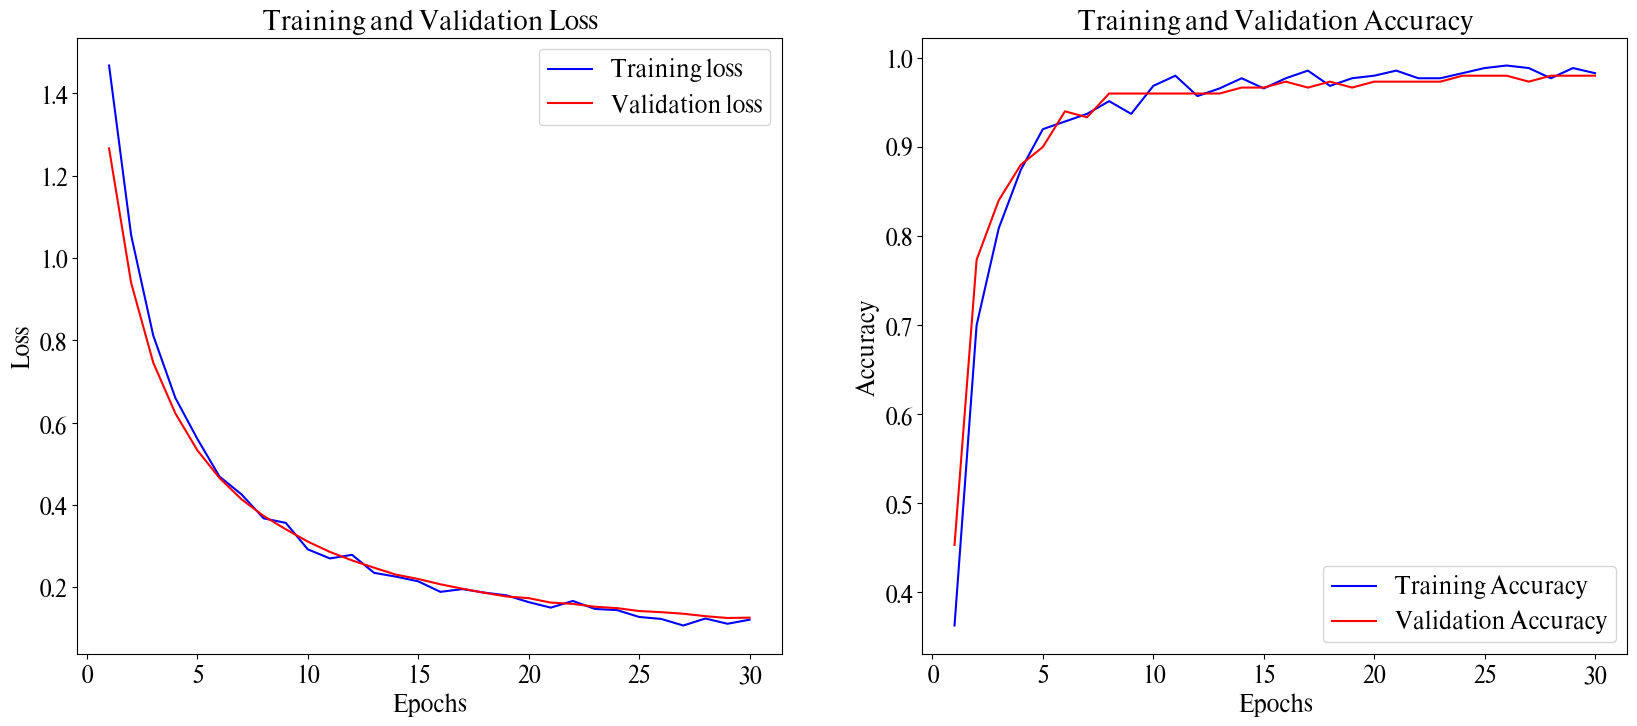

In [33]:
tr_plot_no_best_epoch(history, 0, paths=img_each_model_dir)

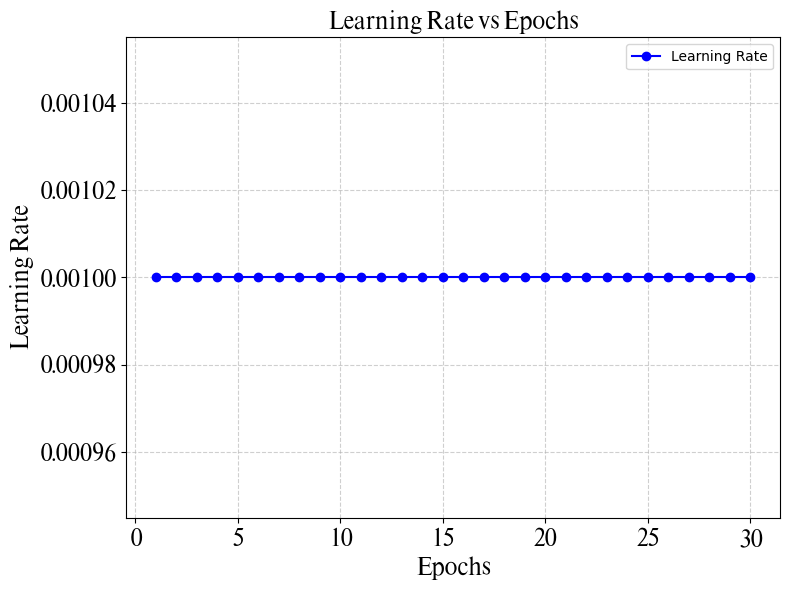

In [34]:
lr_plot(lr_tracker, history, paths=img_each_model_dir)

#**Section 8: Making predictions on the Predict Data**

In [35]:
# พยากรณ์ผลลัพธ์จากโมเดล
predictions = chao_kuay_model.predict(test_images)
# แปลงผลลัพธ์เป็น index ของ class ที่มีค่าความน่าจะเป็นสูงสุด
predicted_indices = np.argmax(predictions, axis=1)
# ดึงข้อมูล mapping ระหว่าง index กับ class name จาก training set
class_index_mapping = train_images.class_indices
# สลับ key กับ value เพื่อแปลงจาก index กลับไปเป็นชื่อ class
index_to_class = dict((v, k) for k, v in class_index_mapping.items())
# แปลง predicted index ให้เป็นชื่อ class ที่เกี่ยวข้อง
predicted_classes = [index_to_class[index] for index in predicted_indices]

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


##**Incorrect Predicted**

In [36]:
incorrect_index = [i for i in range(len(TEST_DF)) if TEST_DF.Label.iloc[i] != predicted_classes[i]]

# สร้าง DataFrame ใหม่ที่มีเฉพาะแถวที่ทำนายผิด
misclassified_df = TEST_DF.iloc[incorrect_index].copy()
# เพิ่มคอลัมน์ Predicted Label ลงใน DataFrame
misclassified_df['Predicted Label'] = [predicted_classes[i] for i in incorrect_index]  # เปลี่ยนชื่อให้ตรงกับที่ต้องการ
# เลือกคอลัมน์ Filepath, Label (True Label), และ Predicted Label
result_misclass_df = misclassified_df[['Filepath', 'Label', 'Predicted Label']]
# เปลี่ยนชื่อคอลัมน์ Label เป็น True Label
result_misclass_df = result_misclass_df.rename(columns={'Label': 'True Label'})

print("Misclassified Dataframe Detail:")
result_misclass_df

Misclassified Dataframe Detail:


,Filepath,True Label,Predicted Label
21,/content/pred_img/4_13.jpg,Rice Leaf Scald,Rice Stackburn
32,/content/pred_img/8_13.jpg,Rice White Tip,Rice Leaf Scald
33,/content/pred_img/2_12.jpg,Rice Leaf Smut,Rice Stackburn
54,/content/pred_img/8_11.jpg,Rice White Tip,Rice Leaf Scald


In [37]:
y_test = list(TEST_DF.Label)
report = classification_report(y_test, predicted_classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Bacterial Leaf Streak,1.000000,1.000000,1.000000,8.000000
Rice Leaf Scald,0.875000,0.933333,0.903226,15.000000
Rice Leaf Smut,1.000000,0.933333,0.965517,15.000000
Rice Stackburn,0.777778,1.000000,0.875000,7.000000
Rice White Tip,1.000000,0.866667,0.928571,15.000000
accuracy,0.933333,0.933333,0.933333,0.933333
macro avg,0.930556,0.946667,0.934463,60.000000
weighted avg,0.942824,0.933333,0.934745,60.000000


##**Plot ROC Curve**

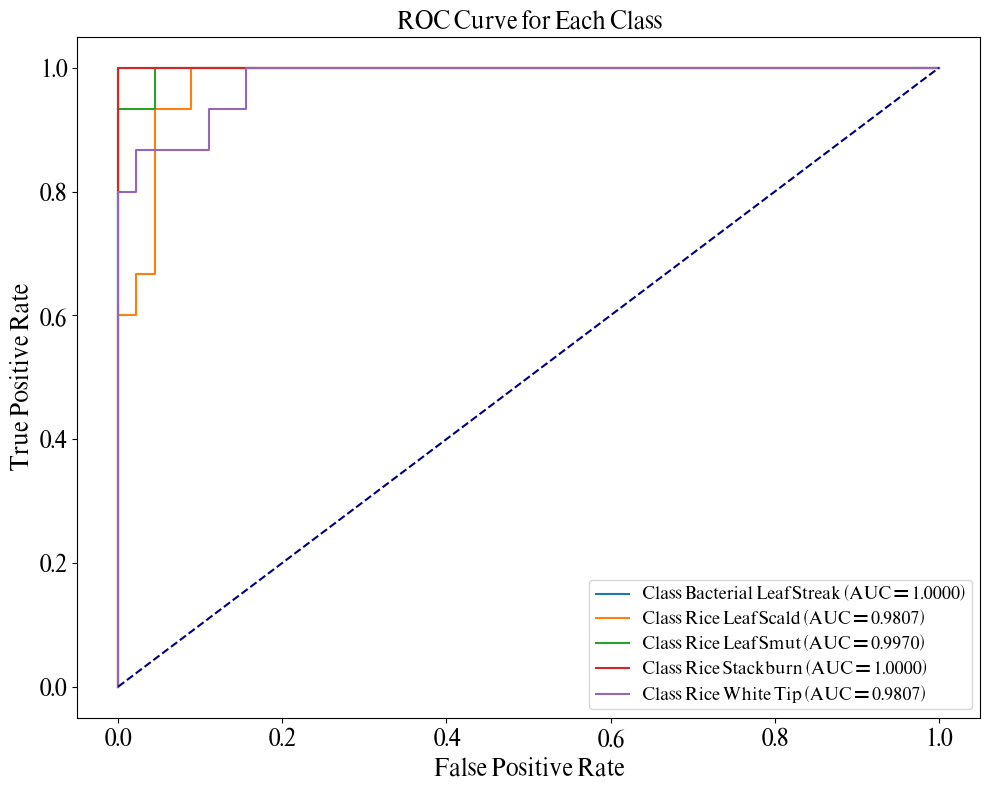

In [38]:
plot_roc_curve(y_test, predictions, paths=img_each_model_dir)

##**Plot Confusion Matrix**

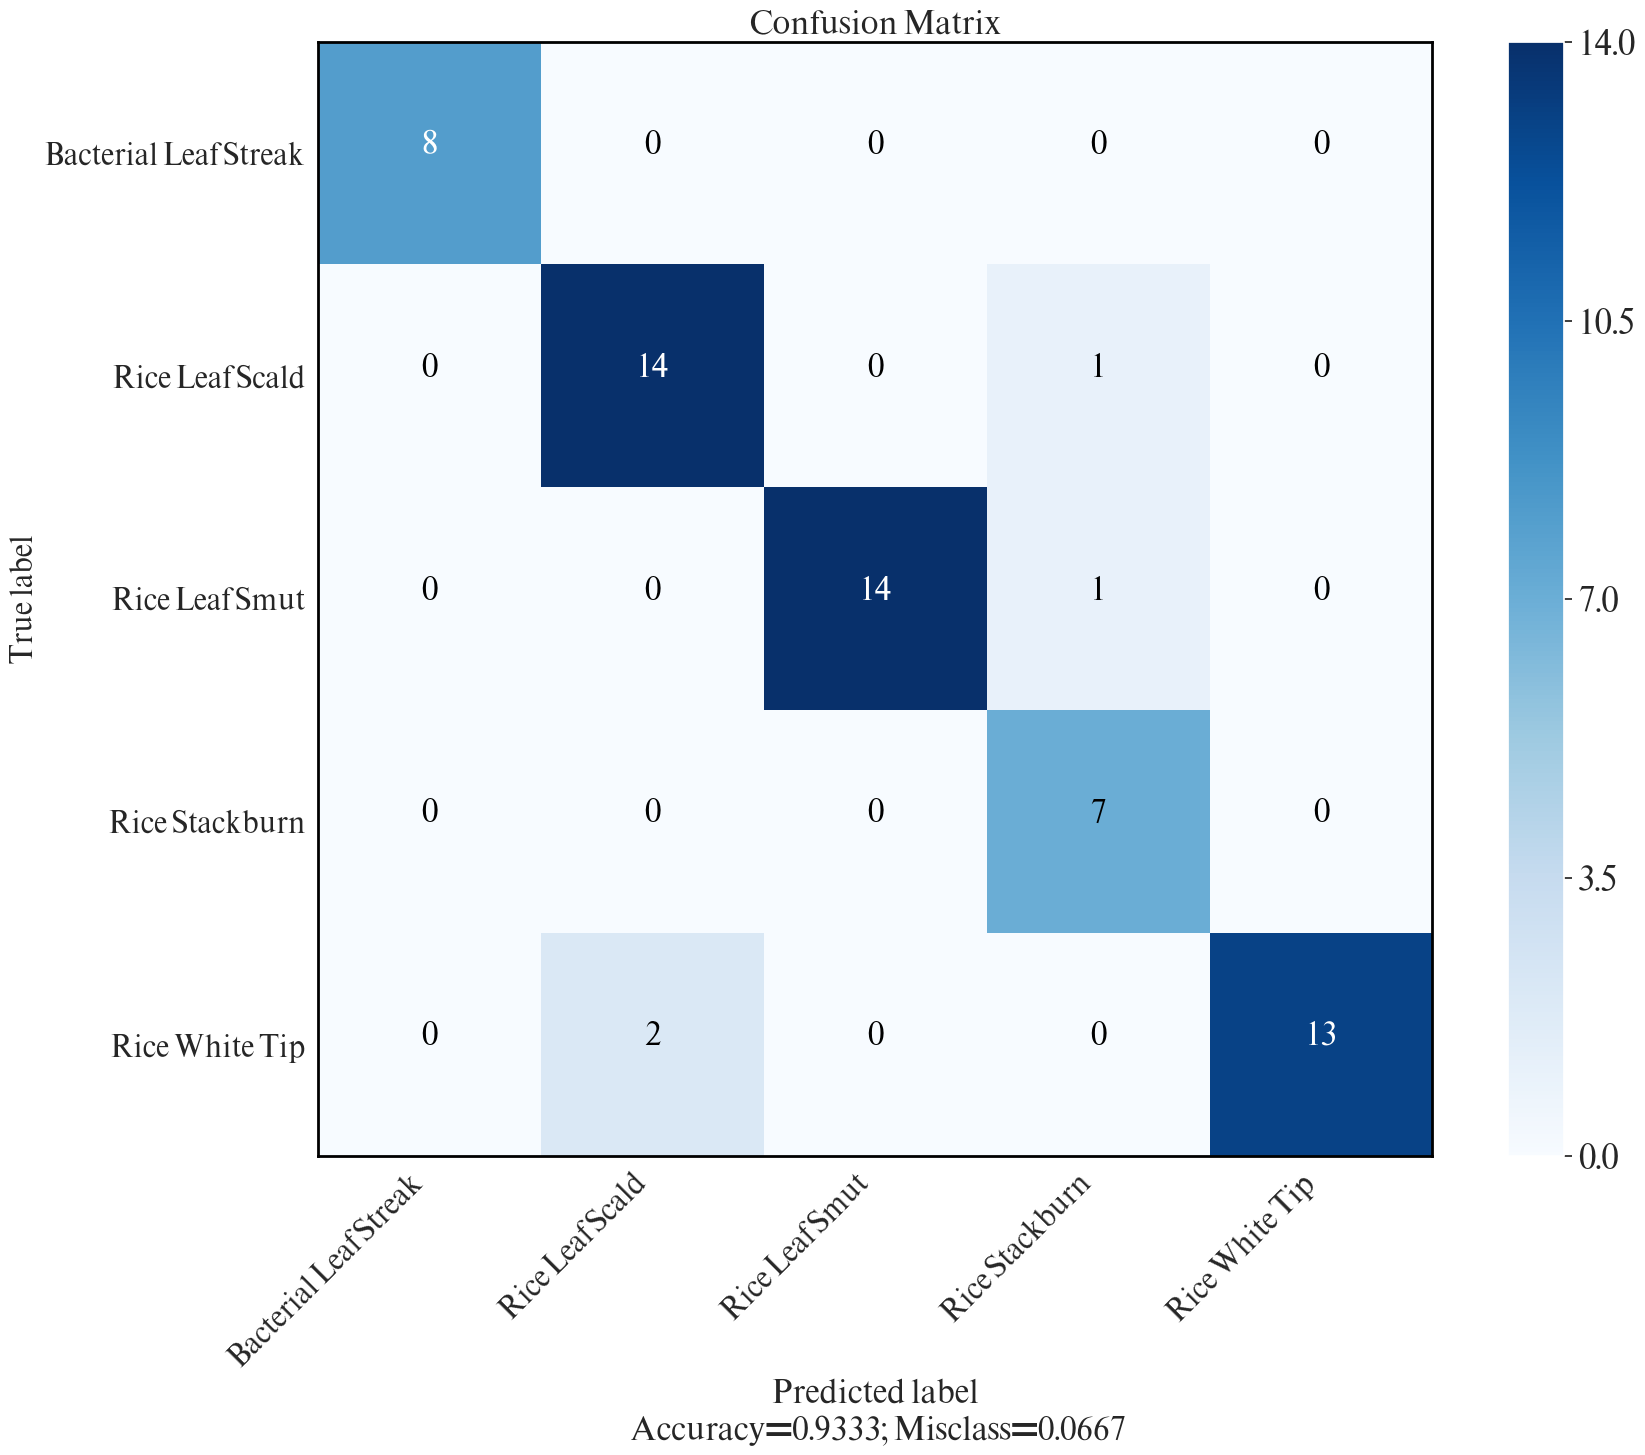

In [39]:
target_names = list(index_to_class.values())
cm = confusion_matrix(y_test, predicted_classes)
plot_confusion_matrix(cm=cm, target_names=target_names, title='Confusion Matrix', fontsize=20, paths=img_each_model_dir)

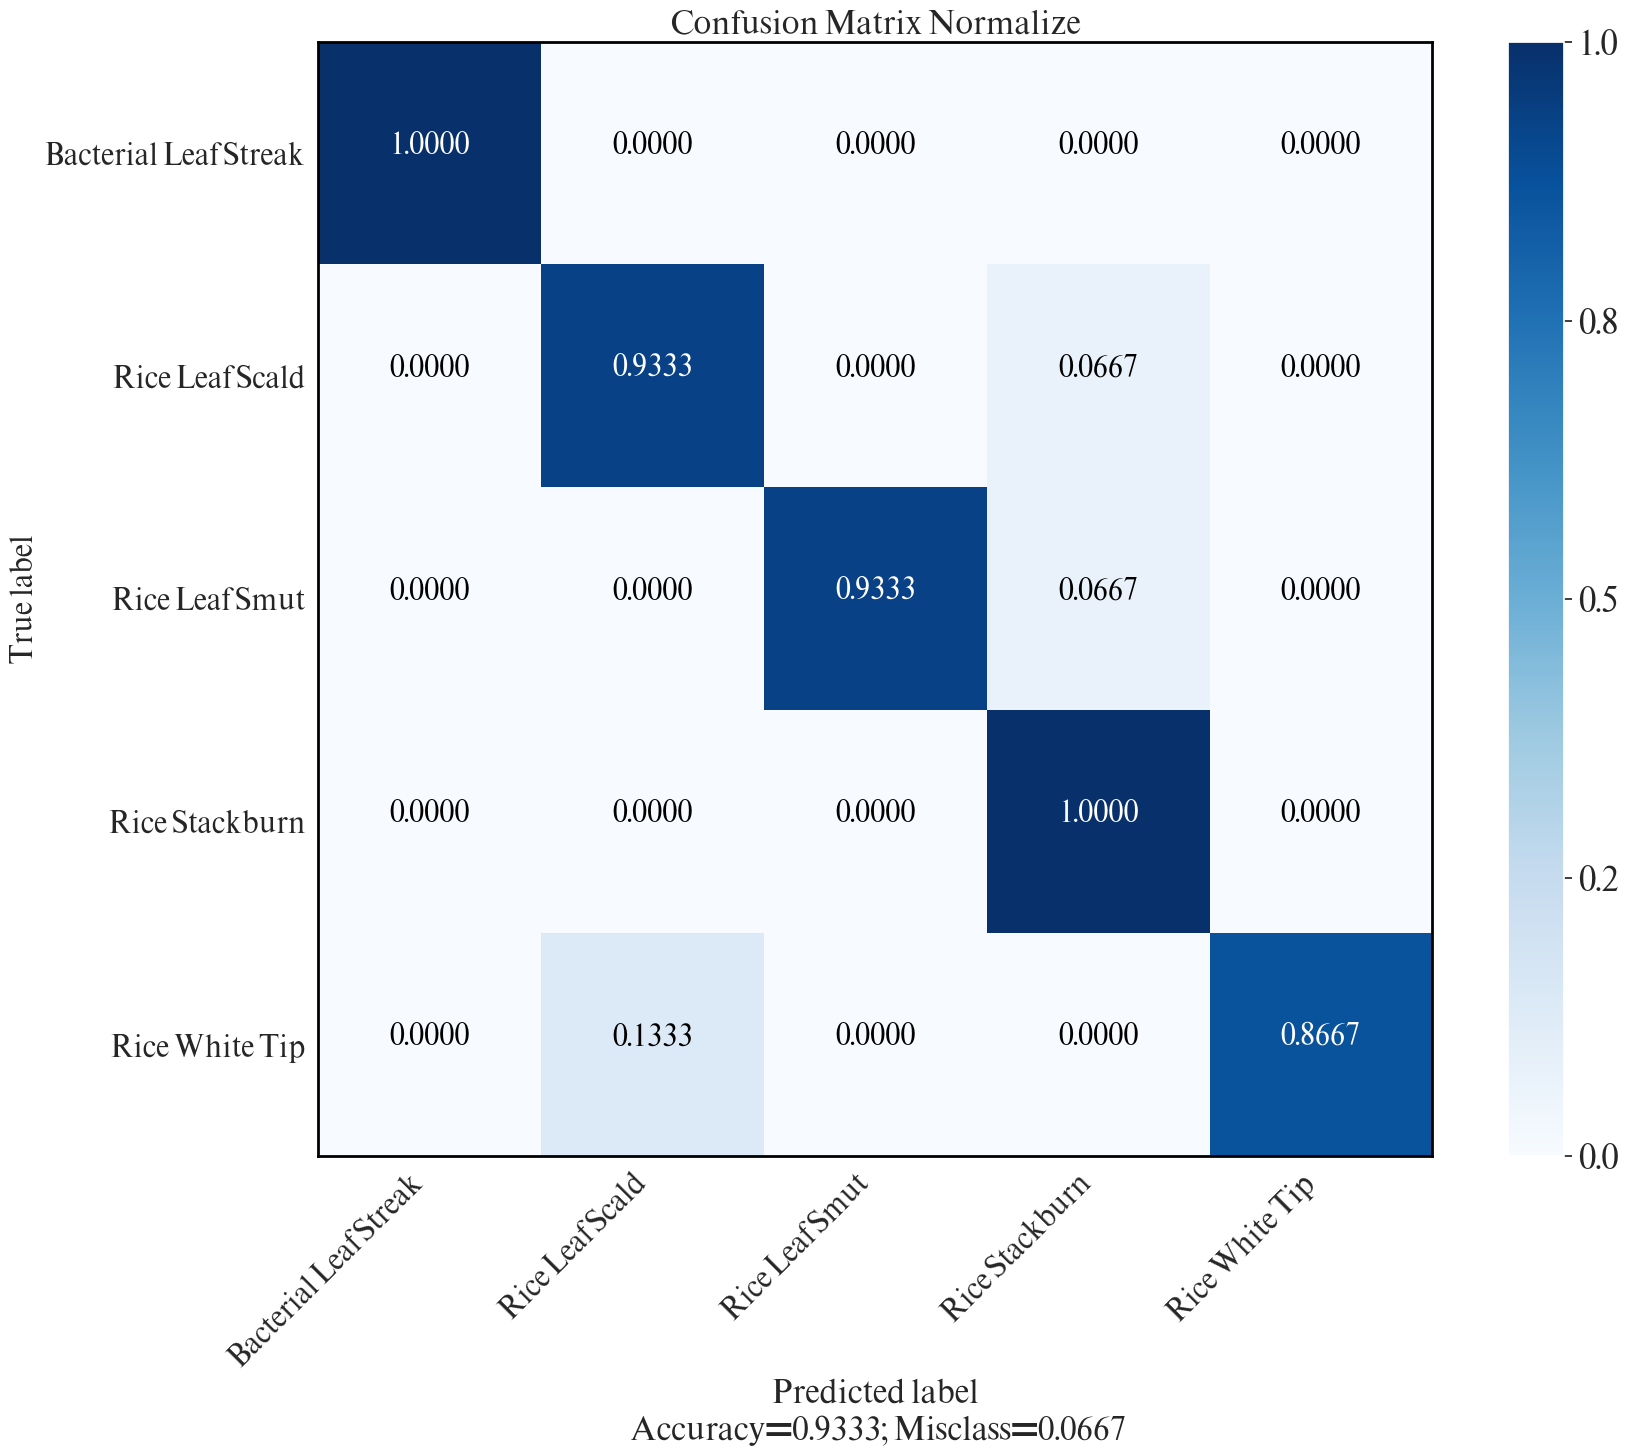

In [40]:
plot_confusion_matrix(cm=cm, target_names=target_names, title='Confusion Matrix Normalize', normalize = True, fontsize=20, paths=img_each_model_dir)

##**Load Model Test**

In [41]:
load_model = keras.saving.load_model(save_path_keras)

In [42]:
start_time_evaluate = time()
test_acc_load = load_model.evaluate(test_images, verbose=1)
print(f"Final Test Accuracy: {test_acc_load[1]}, Final Test Loss: {test_acc_load[0]}")
end_time_evaluate = time()
evaluate_time = end_time_evaluate - start_time_evaluate
hours, remainder = divmod(evaluate_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Evaluation time: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 695ms/step - accuracy: 0.9546 - loss: 0.2364
Final Test Accuracy: 0.9333333373069763, Final Test Loss: 0.29830899834632874
Evaluation time: 0 hours, 0 minutes, 7.19 seconds
